In [1]:
"""import numpy as np #linear algebra
import pandas as pd # 데이터 전처리와 csv 파일 입출력용

from subprocess import check_output
print(check_output(['ls','input']).decode('utf8'))"""

"import numpy as np #linear algebra\nimport pandas as pd # 데이터 전처리와 csv 파일 입출력용\n\nfrom subprocess import check_output\nprint(check_output(['ls','input']).decode('utf8'))"

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [3]:
# Load the data
train = pd.read_json('input/train.json/data/processed/train.json')

In [4]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
test = pd.read_json('input/test.json/data/processed/test.json')

# Intro about the Data

Sentinet -1 sat는 지구 위 약 680km에 있습니다. 특정 입사각에서 신호 펄스를 전송한 다음 다시 기록합니다. 기본적으로 이러한 반사 신호를 후방 산란(backscatter)이라고합니다. 우리가 받은 데이터는 후방 산란 계수로, 다음과 같이 주어진 일반적인 형태의 후방 산란 계수입니다.

σo(dB)=βo(dB)+10log10[sin(ip)/sin(ic)]

1. ip = 특정 픽셀의 입사각
2. ic = 이미지 중앙의 입사각
3. K = 상수

우리는 데이터에서 직접 σo를 받았습니다.

### Now coming to the features of σo
기본적으로 σo는 신호가 산란되는 표면에 따라 다릅니다. 예를 들어 특정 입사각의 경우 다음과 같이 다양합니다.

WATER........... SETTLEMENTS........ AGRICULTURE........... BARREN........

1.HH: -27.001 ................ 2.70252 ................. -12.7952 ................ -17.25790909

2.HV: -28.035 ................ -20.2665 .................. -21.4471 ................. -20.019

보시다시피 HH 구성 요소는 많이 다르지만 HV는 그렇지 않습니다. 배에서 산란에 대한 데이터는 없지만 금속 물체이기 때문에 얼음 물체와는 다르게 달라야합니다.

### WTF is HH HV?
이 센티널 세탈 라이트는 RISTSAT (인도 원격 감지 Sat)와 동일하며 V 편광이 아닌 H 편광에서만 핑을 전송합니다. 이러한 H- 핑이 흩어지고 물체는 편광을 변경하고 H와 V의 혼합으로 반환됩니다. Sentinel에는 H- 송신기 만 있기 때문에 반환 신호는 HH 및 HV 형식 만 있습니다. VV가 주어지지 않은 이유를 묻지 마십시오 (Sentinel에는 V-ping 송신기가 없기 때문입니다).

이제 기능에 대해 설명하겠습니다.이 데모 코드의 목적을 위해 두 대역을 모두 추출하고 평균을 3 채널로 가져와 3 채널 RGB 등가물을 만듭니다.

## Data set
* id: 이미지의 id
* band_1, band_2: 병합된 이미지 데이터. 각 밴드에는 75X75 픽셀 값이 리스트에 저장되어 있으므로 한 행 당 총 5625개의 elements들 존재. 이 값은 물리적인 의미가 있기 때문에 음이 아닌 일반 정수가 아님. band_1과 band_2는 특정 입사각에서 서로 다른 편광에서 생성된 레이더 backscatter이 특징인 신호. 편광은 HH(수평 전송/수신) 및 HB(수평 전송 및 수직 수신)에 해당. 
* inc_angle: 이미지가 촬영된 입사각
* is_iceberg: 대상 변수, 빙산이면 1로 설정하고 배이면 0으로 설정

In [6]:
# training data 생성
# HH, HV 및 평균이 모두있는 3 개의 밴드 생성
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_2']])
X_train = np.concatenate([X_band_1[:,:,:, np.newaxis], X_band_2[:,:,:,np.newaxis], ((X_band_1+X_band_2)/2)[:,:,:,np.newaxis]], axis=-1)

In [7]:
len(train['band_1'][0])

5625

In [8]:
75*75

5625

In [9]:
X_band_1[0].shape

(75, 75)

In [10]:
X_band_1.shape

(1604, 75, 75)

In [11]:
train.shape

(1604, 5)

In [12]:
X_band_1[0]

array([[-27.87836 , -27.15416 , -28.668615, ..., -25.573483, -26.488674,
        -30.507013],
       [-28.66853 , -27.8784  , -27.508776, ..., -26.488632, -28.671562,
        -31.594166],
       [-28.66853 , -27.15416 , -25.865042, ..., -27.157106, -27.881393,
        -32.837124],
       ...,
       [-29.092905, -28.669163, -30.504612, ..., -30.011005, -25.868538,
        -26.489265],
       [-31.591682, -27.878992, -28.669205, ..., -27.512272, -26.817074,
        -27.512358],
       [-29.092905, -26.814081, -27.15479 , ..., -26.817032, -27.881983,
        -28.268127]], dtype=float32)

In [13]:
X_train

array([[[[-27.87836 , -27.154118, -27.51624 ],
         [-27.15416 , -29.537888, -28.346024],
         [-28.668615, -31.0306  , -29.849607],
         ...,
         [-25.573483, -29.095308, -27.334396],
         [-26.488674, -29.540878, -28.014776],
         [-30.507013, -27.511766, -29.00939 ]],

        [[-28.66853 , -31.030518, -29.849524],
         [-27.8784  , -33.529335, -30.703869],
         [-27.508776, -31.591175, -29.549976],
         ...,
         [-26.488632, -34.288055, -30.388344],
         [-28.671562, -28.267496, -28.469528],
         [-31.594166, -26.488716, -29.041441]],

        [[-28.66853 , -33.52929 , -31.09891 ],
         [-27.15416 , -37.05116 , -32.10266 ],
         [-25.865042, -31.591175, -28.728107],
         ...,
         [-27.157106, -31.594084, -29.375595],
         [-27.881393, -32.19339 , -30.037392],
         [-32.837124, -29.54092 , -31.189022]],

        ...,

        [[-29.092905, -27.87895 , -28.485928],
         [-28.669163, -27.878992, -28.274078]

### X_band_1[:,:,:, np.newaxis]
* 기존의 3차원(1604, 75, 75)에 길이가 1인 새로운 축 추가

### np.concatenate
* axis = -1은 마지막 차원 수 의미
* axis = 1은 2차원 이상, 1차원은 axis = 0

<참고>
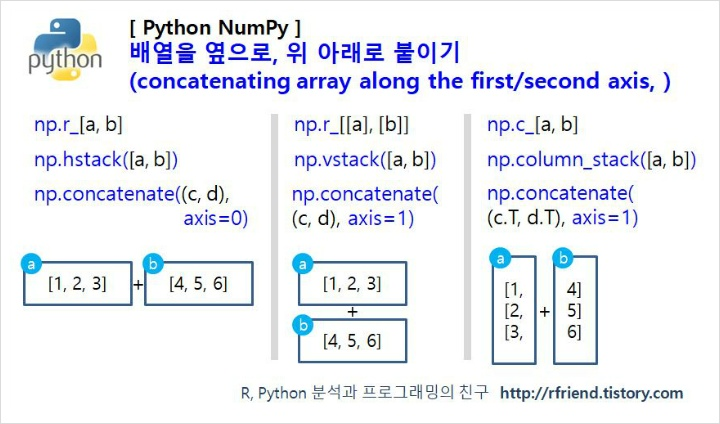


In [15]:
!pip install plotly

  Using cached plotly-4.9.0-py2.py3-none-any.whl (12.9 MB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=3b0e58875389c8faee7eb59f99973f8a6a8379bd1825cc970ee7cbeab266ca41
  Stored in directory: c:\users\dldud\appdata\local\pip\cache\wheels\ac\cb\8a\b27bf6323e2f4c462dcbf77d70b7c5e7868a7fbe12871770cf
Successfully built retrying


In [16]:
# 빙산(iceberg) 살펴보기
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plotmy3d(c, name):
    
    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title = name,
        autosize = False,
        width = 700,
        height = 700,
        margin = dict(
            l = 65,
            r = 50, 
            b = 65,
            t = 90
        )
    )
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)
    
plotmy3d(X_band_1[2,:,:], 'iceberg')

In [17]:
X_band_1[12,:,:].shape

(75, 75)

그것은 우리가 가지고있는 멋진 빙산입니다. 레이더 데이터에서 빙산의 모양은 여기에 표시된 것처럼 산과 같을 것임을 기억하십시오. 이것은 실제 이미지가 아니라 레이더에서 산란되기 때문에 모양에 이와 같은 봉우리와 왜곡이 있을 것입니다. 배의 모양은 점처럼 될 것이고, 길쭉한 점처럼 될 수 있습니다. 여기에서 구조적 차이가 발생하고 CNN을 사용하여 이러한 차이를 활용할 수 있습니다. 레이더의 후방 산란을 사용하여 합성 이미지를 만들 수 있다면 도움이 될 것입니다.

In [18]:
plotmy3d(X_band_1[14, :,:], 'Ship')

그것은 배입니다. 길쭉한 점처럼 보입니다. 배의 모양을 시각화하기위한 이미지의 해상도가 많지 않습니다. 그러나 CNN이 도와 드리겠습니다.
그러나 그들의 데이터는 훨씬 더 나은 해상도를 가지고 있어서 그들이 사용한 CNN이 여기에 적합 할 것이라고 생각하지 않습니다.

In [22]:
# import keras
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [20]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [23]:
# 모델 정의
def getModel():
    # 모델 구축
    gmodel = Sequential()
    
    # 컨볼루션 층 1
    gmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (75,75,3)))
    gmodel.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    gmodel.add(Dropout(0.2))
    
    # 컨볼루션 층 2
    gmodel.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    gmodel.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    gmodel.add(Dropout(0.2))
    
    # 컨볼루션 층 3
    gmodel.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    gmodel.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    gmodel.add(Dropout(0.2))
    
    # 컨볼루션 층 4
    gmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    gmodel.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    gmodel.add(Dropout(0.2))
    
    # 밀집 층들을 위해 데이터 펼치기
    gmodel.add(Flatten())
    
    # 밀집 층들
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    
    # 밀집 층 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    
    # 시그모이드 층
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))
    
    myoptim = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
    gmodel.compile(loss = 'binary_crossentropy',
                  optimizer = myoptim,
                  metrics = ['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience = 2):
    es = EarlyStopping('val_loss', patience= patience, mode = 'min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = '.model_weights.hdf5'
callbacks = get_callbacks(filepath = file_path, patience = 5)

In [24]:
target_train = train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state = 1, train_size = 0.75)

In [25]:
# 노이즈 제거 없이, 핵심 피처들
import os
gmodel = getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size = 24,
          epochs = 50,
          verbose = 1,
          validation_data = (X_valid, y_valid),
          callbacks = callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       1

In [28]:
gmodel.load_weights(filepath = file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose = 1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

13/13 [==============================] - 1s 99ms/step - loss: 0.2649 - accuracy: 0.8878
Test loss:  0.2648690342903137
Test accuracy:  0.8877805471420288


In [30]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

In [31]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

In [33]:
submission

,id,is_iceberg
0,5941774d,1.602940e-01
1,4023181e,4.369540e-01
2,b20200e4,1.000000e+00
3,e7f018bb,9.993990e-01
4,4371c8c3,9.285067e-01
...,...,...
8419,16ee9b50,3.435853e-21
8420,5a599eb7,3.414885e-01
8421,df30d6dd,3.006905e-03
8422,18af95b1,9.990194e-01
